 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#Reference" data-toc-modified-id="Reference-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reference</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#generate-graph" data-toc-modified-id="generate-graph-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generate graph</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#simple-neural-network" data-toc-modified-id="simple-neural-network-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>simple neural network</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#测试前要看一下" data-toc-modified-id="测试前要看一下-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>测试前要看一下</a></span></li></ul></li></ul></li></ul></div>

# Reference

https://medium.com/@bgoncalves/network-effects-explained-pagerank-and-preferential-attachment-61fdf93d023a

# Code

## generate graph

In [1]:
import networkx as nx

In [2]:
with open("web-Stanford.txt","r") as fil:
    for _ in range(4):
        next(fil)
    data=[tuple([int(j) for j in i.strip().split()]) for i in fil]

In [3]:
G = nx.DiGraph()
G.add_edges_from(data)

pr = nx.pagerank(G, alpha=0.9)   #作为true response?

In [20]:
for i in pr.keys():
    G[i]['score']=pr[i]

In [21]:
G[1]['score']

3.561215144991757e-07

In [22]:
n=len(G.nodes())

### Preferential Attachment Model
命名和上一个一样

In [2]:
G_temp = nx.barabasi_albert_graph(1000, 1)

# initialize an empty directed graph
G = nx.DiGraph()
G.add_edges_from(G_temp.edges())

pr = nx.pagerank(G, alpha = 0.86) 
for i in pr.keys():
    G[i]['score']=pr[i]

In [3]:
G[1]['score']

0.0007736768525346217

In [4]:
n=len(G.nodes())

## simple neural network

In [5]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

import scipy.sparse as sp
import random
import numpy as np

### 测试前要看一下
+ 之前学习率填了0.05，明显训练的时候有了误差来回变大减小又变大再减小的情况，应该要调小一点，之前作业里是0.01,我一时兴起又改大了……
+ 用networkx里的pagerank算法出来的分数是在0-1之间，所以最后的误差出来即使是0.几，也不确定是不是很好，这里是100个点做validation。
+ epoch可能也要调，学习率0.05的时候300差不多收敛了，但是不知道学习率改了之后是什么情况

In [6]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'  #这行应该并没有什么用
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.05, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 300, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

If you assume the target is continuous (like PageRank scores here) and normally distributed, and you maximize the likelihood of the output of the net under these assumptions, you get the MSE (combined with a linear output layer).

In [20]:
def masked_mean_square_error(preds,labels,mask):
    """L2 loss with masking."""
    loss = tf.nn.l2_loss(preds - labels)   
    # loss = tf.nn.relu(preds - labels) Rulu loss
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

# 定义另一个loss function
def masked_absolute_difference(preds,labels,mask):
    """Log Loss with masking"""
    loss = tf.losses.absolute_difference(labels = labels, predictions = preds)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

#--------------------Evaluation function------------------------#

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

## 因为response是continuous，是不是应该用RMSE instead of accuracy? (accuracy是针对分类问题)
def masked_accuracy(preds, labels, mask):
    """Root Mean Square Error with masking"""
    rmse = tf.metrics.root_mean_squared_error(labels = labels, predictions = preds)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    rmse *= mask
    return tf.reduce_mean(rmse)

**Cross Entropy vs. Mean Square Error**

Cross-entropy is prefered for **classification**, while mean squared error is one of the best choices for **regression**. This comes directly from the statement of the problems itself - in classification you work with very particular set of possible output values thus MSE is badly defined (as it does not have this kind of knowledge thus penalizes errors in incompatible way). 

In [21]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # loss function 可尝试多种
        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
                                                 self.placeholders['labels_mask'])
#        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
#                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return self.outputs    #tf.nn.softmax(self.outputs)

In [22]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

# A^2
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)

In [23]:
# Randomly generate graph with 500 nodes
adj = nx.adjacency_matrix(G)

# Generate feature matrix  #there is difference between different version of networkx, 这里是用networkx 2.0. 原来1.1的用法注释掉了
#features = sp.vstack(list(j[1] for j in G.in_degree(G.nodes())),dtype = 'float32').tolil()
features = sp.vstack(list(G.in_degree(G.nodes()).values()),dtype = 'float32').tolil()   

# Feed labels to 20 nodes
label = []
for i in G.nodes():
    #label.append(G.nodes[i]['score']) 我用的1.1语法  -yiming
    label.append(G[i]['score'])
        
alabel = np.array(label, dtype='float64')

idx_train = range(500)
idx_val = range(500, 500 + 100) #20000改到500 for preferential attachment model

y_train = np.zeros([n, 1])   #n is number of total nodes, =281903
train_mask = np.zeros([n, ], dtype = 'bool')
for i in idx_train:
    y_train[i] = alabel[i]
    train_mask[i] = True

y_val = np.zeros([n, 1])
val_mask = np.zeros([n, ], dtype = 'bool')
for i in idx_val:
    y_val[i] = alabel[i]
    val_mask[i] = True

In [24]:
# Load data
#adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

/Users/Yiming/Desktop/Homework/IE 532/Project/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [25]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

FailedPreconditionError: Attempting to use uninitialized value root_mean_squared_error/count
	 [[Node: root_mean_squared_error/count/read = Identity[T=DT_FLOAT, _class=["loc:@root_mean_squared_error/count"], _device="/job:localhost/replica:0/task:0/cpu:0"](root_mean_squared_error/count)]]

Caused by op 'root_mean_squared_error/count/read', defined at:
  File "/anaconda/envs/Python3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/envs/Python3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-0a5712b52967>", line 32, in <module>
    model = model_func(placeholders, input_dim=features[2][1], logging=True)
  File "<ipython-input-21-9d0114ec2302>", line 13, in __init__
    self.build()
  File "/Users/Yiming/Desktop/Homework/IE 532/Project/gcn/models.py", line 56, in build
    self._accuracy()
  File "<ipython-input-21-9d0114ec2302>", line 28, in _accuracy
    self.placeholders['labels_mask'])
  File "<ipython-input-20-5fbb096503bf>", line 33, in masked_accuracy
    rmse = tf.metrics.root_mean_squared_error(labels = labels, predictions = preds)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py", line 2062, in root_mean_squared_error
    name or 'root_mean_squared_error')
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py", line 1055, in mean_squared_error
    updates_collections, name or 'mean_squared_error')
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py", line 333, in mean
    count = _create_local('count', shape=[])
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py", line 197, in _create_local
    validate_shape=validate_shape)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 316, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1338, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value root_mean_squared_error/count
	 [[Node: root_mean_squared_error/count/read = Identity[T=DT_FLOAT, _class=["loc:@root_mean_squared_error/count"], _device="/job:localhost/replica:0/task:0/cpu:0"](root_mean_squared_error/count)]]


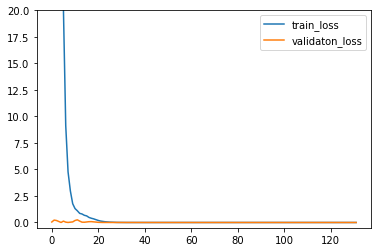

In [13]:
import matplotlib.pyplot as plt
plt.figure()
# plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
# plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.ylim(-0.5, 20)
plt.legend()
plt.savefig("mse_learning0.05.png")
plt.show()

- 若learning rate = 0.01, train_loss一开始很大，在epoch = 100左右急剧减小
- 若learning rate = 0.05, train_loss一开始很大，在epoch = 20左右急剧减小

Presentation时可以做的几个比较：

1. 不同的learning_rate
2. 不同的drop_out rate
3. 不同的Loss function
4. 有无weight_decay
5. 不同的adjacency matrix, A, A^2等等